In [1]:
# 한글

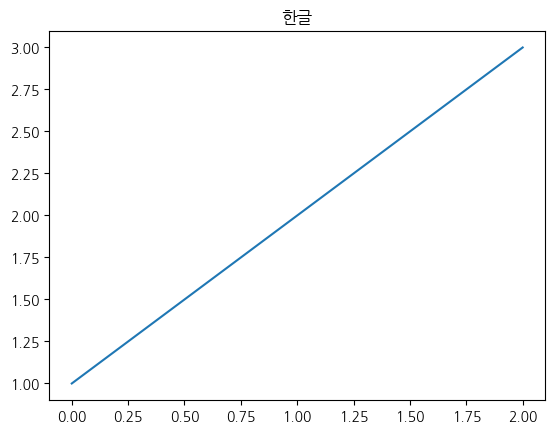

In [2]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

In [3]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max.columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

In [5]:
df = pd.read_csv('data/for_ship_model.csv')

In [6]:
df.columns = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호', '접안_대기시간_분',
       '계선장소명', '선박용도', 'Service_Time_분', '대기율', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded']

x_cols = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour',
       'Service_Time_분', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
        '파주기', '파향', '이전_입항선박수','시설연평균_재화중량톤수', 
        '연평균_총입항건수', '선박_연평균_서비스시간', '계선장소명_encoded', '선박용도_encoded']

df.head(2)

,ETA_Year,ETA_Month,ETA_Day,ETA_Hour,호출부호,접안_대기시간_분,계선장소명,선박용도,Service_Time_분,대기율,총톤수,재화중량톤수,선박_총길이,선박_너비,선박_만재흘수,선박_깊이,선박_길이1,풍속,풍향,GUST풍속,현지기압,습도,기온,수온,최대파고,유의파고,평균파고,파주기,파향,이전_입항선박수,연도별_선석점유율,시설연평균_재화중량톤수,연평균_총입항건수,선박_연평균_서비스시간,선박_연평균_대기시간,호출부호_encoded,계선장소명_encoded,선박용도_encoded
0,2020,1,1,1,88238,0,SK2부두 01,석유제품 운반선,430.0,0.0,700.0,0.0,70.9,12.0,3.9,5.35,66.01,9.3,330.0,12.2,1028.8,43.0,4.3,17.5,4.2,2.8,2.0,10.7,49.0,0,4.143219,2073.888986,1729.000000,1452.987426,572.048817,0,0,0
1,2020,1,1,3,DSRB9,0,가스부두,LPG 운반선,710.0,0.0,2689.0,2999.0,96.0,15.0,7.2,7.20,90.10,12.6,315.0,15.3,1028.5,44.0,4.3,17.4,3.9,2.2,1.5,9.1,48.0,0,1.742879,3935.463021,418.333333,970.370370,215.740741,1,1,1


## 3차 : 파라미터 추가
- subsample , colsample by tree

In [7]:
# 데이터 불러오기 (주어진 데이터 사용)
data = df.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.3),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.9),  # feature_fraction의 범위 설정
    'max_depth': (3, 15),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1),              # reg_lambda의 범위 설정
    #'max_bin': (5, 500),              # max_bin의 범위 설정
    'subsample': (0.5, 1.0),          # subsample의 범위 설정
    'colsample_bytree': (0.5, 1.0)    # colsample_bytree의 범위 설정
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda, subsample, colsample_bytree):
    params = {
        'objective': 'regression',  # 회귀 문제 설정
        'metric': 'rmse',          # 평가 지표 (Root Mean Squared Error)
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),  # learning_rate를 0과 1 사이로 제한
        'feature_fraction': max(min(feature_fraction, 1), 0),  # feature_fraction을 0과 1 사이로 제한
        'max_depth':int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0),
       # 'max_bin': int(max_bin),
        'subsample': max(min(subsample, 1), 0),
        'colsample_bytree': max(min(colsample_bytree, 1), 0)
    }

    model = lgb.LGBMRegressor(**params)

    # 모델 학습
    model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = model.predict(X_test)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return -rmse  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=12,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=10)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)



# 최적 하이퍼파라미터로 모델 학습 및 평가
best_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    feature_fraction=best_params['feature_fraction'],
    min_child_samples=int(best_params['min_child_samples']),
    reg_lambda=best_params['reg_lambda'],
    # max_bin=int(best_params['max_bin']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree']
)


best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'테스트 RMSE (최적 모델): {test_rmse}')

|   iter    |  target   | colsam... | featur... | learni... | max_depth | min_ch... | num_le... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.6920397572123238, colsample_bytree=0.5770814211898362 will be ignored. Current value: feature_fraction=0.6920397572123238
| 1         | -1.038e+0 | 0.5771    | 0.692     | 0.08636   | 9.405     | 1.714     | 92.04     | 0.9007    | 0.5167    |
[LightGBM] [Warning] feature_fraction is set=0.20976745708486116, colsample_bytree=0.9784746681375585 will be ignored. Current value: feature_fraction=0.20976745708486116
| 2         | -1.035e+0 | 0.9785    | 0.2098    | 0.09231   | 10.27     | 47.27     | 85.57     | 0.002259  | 0.7606    |
[LightGBM] [Warning] feature_fraction is set=0.4883019309301678, colsample_bytree=0.7760188166322832 will be ignored. Current value: feature_fraction=0.4883019309301678
| 3

|   iter    |  target   | colsam... | featur... | learni... | max_depth | min_ch... | num_le... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.6920397572123238, colsample_bytree=0.5770814211898362 will be ignored. Current value: feature_fraction=0.6920397572123238
RMSE: 1037.6248473482353, MAE: 489.8072823302879
| 1         | -1.038e+0 | 0.5771    | 0.692     | 0.08636   | 9.405     | 1.714     | 92.04     | 0.9007    | 0.5167    |
[LightGBM] [Warning] feature_fraction is set=0.20976745708486116, colsample_bytree=0.9784746681375585 will be ignored. Current value: feature_fraction=0.20976745708486116
RMSE: 1035.102618019396, MAE: 498.57807366049497
| 2         | -1.035e+0 | 0.9785    | 0.2098    | 0.09231   | 10.27     | 47.27     | 85.57     | 0.002259  | 0.7606    |
[LightGBM] [Warning] feature_fraction is set=0.4883019309301678, colsample

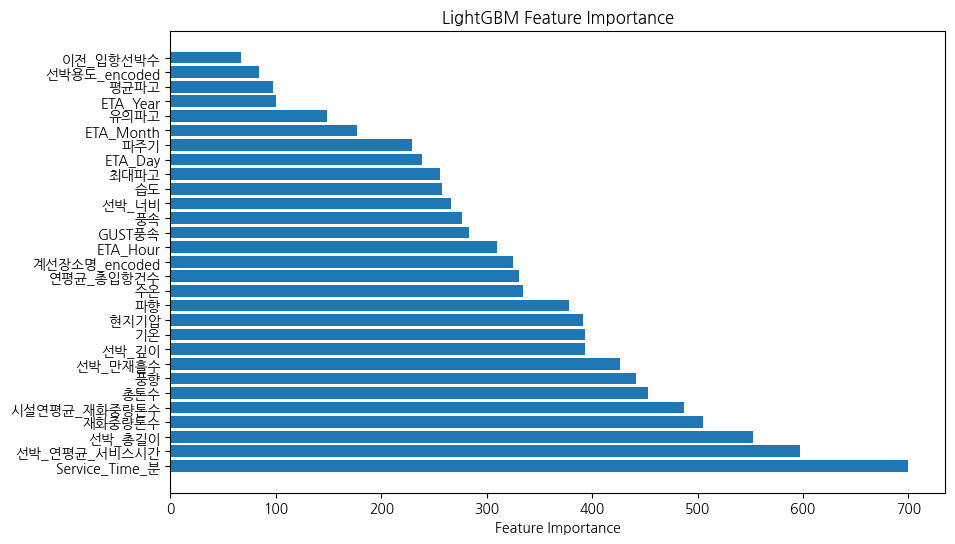

In [8]:
# 필요한 라이브러리 불러오기
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 데이터 불러오기 (주어진 데이터 사용)
data = df.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.3),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.9),  # feature_fraction의 범위 설정
    'max_depth': (3, 15),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1),              # reg_lambda의 범위 설정
    #'max_bin': (5, 500),              # max_bin의 범위 설정
    'subsample': (0.5, 1.0),          # subsample의 범위 설정
    'colsample_bytree': (0.5, 1.0)    # colsample_bytree의 범위 설정
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda, subsample, colsample_bytree):
    params = {
        'objective': 'regression',
        'metric': 'rmse',  # Use RMSE as the default metric for optimization
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),
        'feature_fraction': max(min(feature_fraction, 1), 0),
        'max_depth': int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'colsample_bytree': max(min(colsample_bytree, 1), 0)
    }

    F_model = lgb.LGBMRegressor(**params)
    F_model.fit(X_train, y_train)
    y_pred = F_model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Print RMSE and MAE for each iteration during optimization
    print(f'RMSE: {rmse}, MAE: {mae}')

    return -rmse  # Objective function is to minimize RMSE, so return its negative value
    F_model = lgb.LGBMRegressor(**params)

    # 모델 학습
    F_model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = F_model.predict(X_test)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return -rmse  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=12,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=10)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)



# 최적 하이퍼파라미터로 모델 학습 및 평가
best_F_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    feature_fraction=best_params['feature_fraction'],
    min_child_samples=int(best_params['min_child_samples']),
    reg_lambda=best_params['reg_lambda'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree']
)

best_F_model.fit(X_train, y_train)
y_pred = best_F_model.predict(X_test)

# 테스트 RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)

print(f'테스트 RMSE (최적 모델): {test_rmse}')
print(f'테스트 MAE (최적 모델): {test_mae}')

# 피처 임포턴스 시각화
feature_importance = best_F_model.feature_importances_
feature_names = X.columns

feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_feature_importance = zip(*sorted_feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_feature_importance, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.show()

In [9]:
# 요청 = 피처 임포턴스가 높은 피처의 감소가 예측에 어떤 변화?를 주는지

In [10]:
df1 = pd.read_csv('data/for_ship_model.csv')
df1.columns = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호', '접안_대기시간_분',
       '계선장소명', '선박용도', 'Service_Time_분', '대기율', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded']

In [11]:
df2 = df1[x_cols]

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51001 entries, 0 to 51000
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ETA_Year        51001 non-null  int64  
 1   ETA_Month       51001 non-null  int64  
 2   ETA_Day         51001 non-null  int64  
 3   ETA_Hour        51001 non-null  int64  
 4   Service_Time_분  51001 non-null  float64
 5   총톤수             51001 non-null  float64
 6   재화중량톤수          51001 non-null  float64
 7   선박_총길이          51001 non-null  float64
 8   선박_너비           51001 non-null  float64
 9   선박_만재흘수         51001 non-null  float64
 10  선박_깊이           51001 non-null  float64
 11  풍속              51001 non-null  float64
 12  풍향              51001 non-null  float64
 13  GUST풍속          51001 non-null  float64
 14  현지기압            51001 non-null  float64
 15  습도              51001 non-null  float64
 16  기온              51001 non-null  float64
 17  수온              51001 non-null 

In [13]:
# df2['Service_Time_분'] = df1['Service_Time_분'] * 0.9
# df2['시설연평균_재화중량톤수'] = df1['시설연평균_재화중량톤수'] * 0.9
# df2['선박_연평균_서비스시간'] = df1['선박_연평균_서비스시간'] * 0.9

print(df1.describe().iloc[:,5])
print(df2.describe().iloc[:,4])

count     51001.000000
mean       1980.411149
std       10198.347132
min     -525325.000000
25%         490.000000
50%         940.000000
75%        1950.000000
max      954615.000000
Name: Service_Time_분, dtype: float64
count     51001.000000
mean       1980.411149
std       10198.347132
min     -525325.000000
25%         490.000000
50%         940.000000
75%        1950.000000
max      954615.000000
Name: Service_Time_분, dtype: float64


In [14]:
B = pd.DataFrame({"Before" : y_pred})
B.describe()

,Before
count,10201.000000
mean,425.544745
std,547.029996
min,-1734.597976
25%,39.596594
50%,265.007997
75%,616.206150
max,6543.985334


In [15]:
after_y_pred = best_F_model.predict(df2)

A = pd.DataFrame({"After" : after_y_pred})
A.describe()

,After
count,51001.000000
mean,425.825693
std,595.523782
min,-1734.597976
25%,39.348269
50%,250.428263
75%,596.601966
max,11157.501700


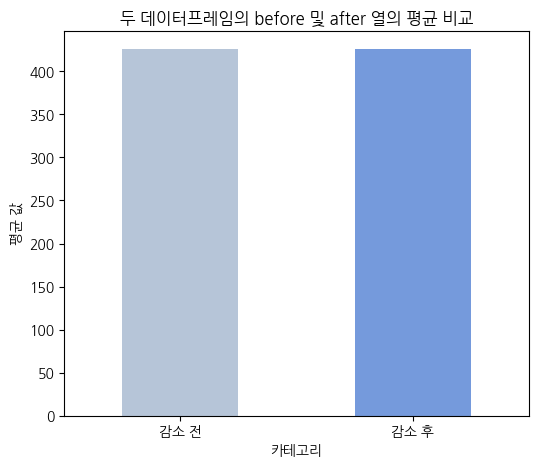

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 'before' 및 'after' 열의 평균 계산
mean_before = B['Before'].mean()
mean_after = A['After'].mean()

# 데이터프레임을 재구성하여 Seaborn에 적합한 형태로 만듭니다.
data = pd.DataFrame({
    'Category': ['감소 전', '감소 후'],
    'Mean_Value': [mean_before, mean_after],
})

plt.figure(figsize=(6, 5))

# Seaborn을 사용하여 막대 그래프 그리기
ax = sns.barplot(x='Category', y='Mean_Value', data=data, palette=['lightsteelblue', 'cornflowerblue'], width=0.5)  # width를 조절하여 홀쭉하게 만듭니다.

# 그래프 설정
plt.title('두 데이터프레임의 before 및 after 열의 평균 비교')
plt.xlabel('카테고리')
plt.ylabel('평균 값')
plt.show()


In [17]:
# 울산항 끝판왕 석유제품 운반선들의 평균을.araboza

df_s = df[df['선박용도'] == "석유제품 운반선"]
# df_s.info()
df_s['계선장소명'].value_counts()
# ==> SK2부두 01          4999 ==> encoded =0

SK2부두 01          4999
현대오일터미널신항부두       2427
장생포호안             2333
S-OIL2부두          2205
SK2부두 02          1944
S-OIL1부두          1403
SK5부두             1089
정일1부두              980
달포부두 01            868
정박지-E1             787
정박지-M1             775
UTK부두              757
정일스톨트헤븐울산신항3부두     747
효성부두               739
SK1부두 11           733
온산2부두              573
신항컨테이너부두 04        556
S-OIL3부두           543
온산1부두              543
정박지-E2             529
정일2부두              525
OTK부두              378
SK1부두 12           363
정박지-E3             340
신항남방파제T/S부두 01     329
신항일반부두 01          323
UTT부두              320
정일스톨트헤븐울산신항4부두     319
정일스톨트헤븐울산신항5부두     276
신항남방파제T/S부두 02     256
SK4부두              231
가스부두               224
SK7부두              212
(구)벙커링전용정박지 E1     208
벙커링전용정박지-B11       205
4부두 01             204
SK8부두              196
S-OIL 4부두 03       193
UTK 신항부두           188
정박지-M4             187
정박지-M5             184
3부두 02             167
SK3부두              162
S-OIL 4부두 0

In [18]:
df_s.describe()

,ETA_Year,ETA_Month,ETA_Day,ETA_Hour,접안_대기시간_분,Service_Time_분,대기율,총톤수,재화중량톤수,선박_총길이,선박_너비,선박_만재흘수,선박_깊이,선박_길이1,풍속,풍향,GUST풍속,현지기압,습도,기온,수온,최대파고,유의파고,평균파고,파주기,파향,이전_입항선박수,연도별_선석점유율,시설연평균_재화중량톤수,연평균_총입항건수,선박_연평균_서비스시간,선박_연평균_대기시간,호출부호_encoded,계선장소명_encoded,선박용도_encoded
count,35960.00000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.000000,35960.0
mean,2021.02361,6.504616,15.794105,12.210234,392.991602,1851.809149,43.416819,4148.103977,6892.040008,83.755734,14.201951,5.475089,7.112504,80.381386,6.012976,190.711925,8.040774,1016.268270,71.148795,17.544839,19.828915,1.946815,1.196940,0.850431,6.053572,115.065013,0.895523,2.868122,6942.822002,619.317153,1927.194096,392.129976,613.815044,27.787180,0.0
std,0.81449,3.485730,8.764596,6.386141,1096.816758,10104.730760,200.088226,9464.646614,16000.401003,40.384077,14.307153,2.398594,4.014451,37.009955,3.059226,109.885504,3.871731,7.445603,16.396907,6.931622,4.271843,1.072886,0.657194,0.466515,2.001009,97.251599,1.356957,2.187607,10043.052720,527.279910,9045.590341,669.242182,734.567579,29.978333,0.0
min,2020.00000,1.000000,1.000000,0.000000,0.000000,-525325.000000,-209.375000,63.000000,0.000000,23.930000,6.000000,0.000000,2.500000,23.900000,0.000000,0.000000,0.100000,841.800000,27.000000,-6.100000,12.400000,0.200000,0.000000,0.000000,2.000000,0.000000,0.000000,0.093750,325.902143,1.000000,-2428.123082,0.000000,0.000000,0.000000,0.0
25%,2020.00000,3.000000,8.000000,8.000000,0.000000,410.000000,0.000000,534.000000,1133.000000,59.400000,10.000000,4.000000,4.600000,60.020000,3.600000,70.000000,5.000000,1010.761174,58.000000,12.400000,15.800000,1.200000,0.700000,0.500000,4.600000,40.797035,0.000000,1.628948,2073.888986,204.666667,824.439099,0.000000,100.000000,6.000000,0.0
50%,2021.00000,7.000000,16.000000,12.000000,0.000000,825.000000,0.000000,1130.000000,2286.000000,74.000000,12.000000,5.000000,5.950000,74.000000,5.900000,222.000000,7.717332,1016.500000,71.000000,17.700000,19.400000,1.700000,1.100000,0.800000,5.800000,64.000000,0.000000,2.030921,3935.463021,479.333333,1227.283861,130.389610,258.000000,20.000000,0.0
75%,2022.00000,10.000000,23.000000,17.000000,185.000000,1775.000000,18.789252,2403.000000,3612.258000,95.225000,15.000000,6.000000,7.300000,84.020000,8.200000,287.000000,10.600000,1021.800000,86.393939,23.100000,23.300000,2.500000,1.500000,1.100000,7.100000,216.000000,1.000000,3.625837,7354.386628,899.333333,1933.068182,594.603367,932.000000,38.000000,0.0
max,2022.00000,12.000000,31.000000,23.000000,37488.000000,954615.000000,31600.000000,228283.000000,312135.000000,399.900000,2402.000000,23.100000,85.000000,385.920000,17.700000,360.000000,111.200000,1035.300000,100.000000,32.400000,30.700000,10.000000,5.800000,4.100000,12.800000,360.000000,11.000000,10.171865,166179.476190,1729.000000,954615.000000,16206.000000,3080.000000,124.000000,0.0


In [19]:
df3 = df2.head(24)
df3['ETA_Year'] = df2['ETA_Year'].median()
df3['ETA_Month'] = df2['ETA_Month'].median()
df3['ETA_Day'] = df2['ETA_Day'].median()
df3['ETA_Hour'] = range(1,25)
df3['Service_Time_분'] = df2['Service_Time_분'].median()
df3['총톤수'] = df2['총톤수'].median()
df3['재화중량톤수'] = df2['재화중량톤수'].median()
df3['선박_총길이'] = df2['선박_총길이'].median()
df3['선박_너비'] = df2['선박_너비'].median()
df3['선박_만재흘수'] = df2['선박_만재흘수'].median()
df3['선박_깊이'] = df2['선박_깊이'].median()
df3['풍속'] = df2['풍속'].median()
df3['풍향'] = df2['풍향'].median()
df3['GUST풍속'] = df2['GUST풍속'].median()
df3['현지기압'] = df2['현지기압'].median()
df3['습도'] = df2['습도'].median()
df3['기온'] = df2['기온'].median()
df3['수온'] = df2['수온'].median()
df3['최대파고'] = df2['최대파고'].median()
df3['유의파고'] = df2['유의파고'].median()
df3['평균파고'] = df2['평균파고'].median()
df3['파주기'] = df2['파주기'].median()
df3['파향'] = df2['파향'].median()
df3['이전_입항선박수'] = df2['이전_입항선박수'].median()
df3['시설연평균_재화중량톤수'] = df2['시설연평균_재화중량톤수'].median()
df3['연평균_총입항건수'] = df2['연평균_총입항건수'].median()
df3['선박_연평균_서비스시간'] = df2['선박_연평균_서비스시간'].median()
df3['계선장소명_encoded'] = df2['계선장소명_encoded'].median()
df3['선박용도_encoded'] = df2['선박용도_encoded'].median()
df3.describe()

,ETA_Year,ETA_Month,ETA_Day,ETA_Hour,Service_Time_분,총톤수,재화중량톤수,선박_총길이,선박_너비,선박_만재흘수,선박_깊이,풍속,풍향,GUST풍속,현지기압,습도,기온,수온,최대파고,유의파고,평균파고,파주기,파향,이전_입항선박수,시설연평균_재화중량톤수,연평균_총입항건수,선박_연평균_서비스시간,계선장소명_encoded,선박용도_encoded
count,24.0,24.0,24.0,24.000000,24.0,24.0,24.0,24.00,24.0,24.0,24.0,2.400000e+01,24.0,24.000000,24.0,24.0,24.0,24.0,24.0,24.0,2.400000e+01,24.0,24.0,24.0,24.00000,24.0,24.000000,24.0,24.0
mean,2021.0,6.0,16.0,12.500000,940.0,1411.0,2398.0,79.99,13.4,5.0,6.2,5.900000e+00,222.0,7.712771,1016.4,71.0,17.7,19.4,1.7,1.1,8.000000e-01,5.8,64.0,0.0,5312.99547,340.0,1377.305058,22.0,0.0
std,0.0,0.0,0.0,7.071068,0.0,0.0,0.0,0.00,0.0,0.0,0.0,9.072812e-16,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.134102e-16,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0
min,2021.0,6.0,16.0,1.000000,940.0,1411.0,2398.0,79.99,13.4,5.0,6.2,5.900000e+00,222.0,7.712771,1016.4,71.0,17.7,19.4,1.7,1.1,8.000000e-01,5.8,64.0,0.0,5312.99547,340.0,1377.305058,22.0,0.0
25%,2021.0,6.0,16.0,6.750000,940.0,1411.0,2398.0,79.99,13.4,5.0,6.2,5.900000e+00,222.0,7.712771,1016.4,71.0,17.7,19.4,1.7,1.1,8.000000e-01,5.8,64.0,0.0,5312.99547,340.0,1377.305058,22.0,0.0
50%,2021.0,6.0,16.0,12.500000,940.0,1411.0,2398.0,79.99,13.4,5.0,6.2,5.900000e+00,222.0,7.712771,1016.4,71.0,17.7,19.4,1.7,1.1,8.000000e-01,5.8,64.0,0.0,5312.99547,340.0,1377.305058,22.0,0.0
75%,2021.0,6.0,16.0,18.250000,940.0,1411.0,2398.0,79.99,13.4,5.0,6.2,5.900000e+00,222.0,7.712771,1016.4,71.0,17.7,19.4,1.7,1.1,8.000000e-01,5.8,64.0,0.0,5312.99547,340.0,1377.305058,22.0,0.0
max,2021.0,6.0,16.0,24.000000,940.0,1411.0,2398.0,79.99,13.4,5.0,6.2,5.900000e+00,222.0,7.712771,1016.4,71.0,17.7,19.4,1.7,1.1,8.000000e-01,5.8,64.0,0.0,5312.99547,340.0,1377.305058,22.0,0.0


In [20]:
df_con = df3['ETA_Hour']

In [21]:
OIL_ship = best_F_model.predict(df3)

DD = pd.DataFrame({"After" : OIL_ship})
DD

,After
0,558.719588
1,570.943745
2,570.943745
3,572.173614
4,572.173614
5,574.357915
6,511.545993
7,511.545993
8,565.061517
9,578.926822


In [22]:
result = pd.concat([df_con, DD], axis=1)
result

,ETA_Hour,After
0,1,558.719588
1,2,570.943745
2,3,570.943745
3,4,572.173614
4,5,572.173614
5,6,574.357915
6,7,511.545993
7,8,511.545993
8,9,565.061517
9,10,578.926822


In [23]:
# 'ETA_Hour' 열이 7 또는 17인 행을 추출
filt_df = result[(result['ETA_Hour'] == 7) | (result['ETA_Hour'] == 17)]
filt_df

,ETA_Hour,After
6,7,511.545993
16,17,680.060394


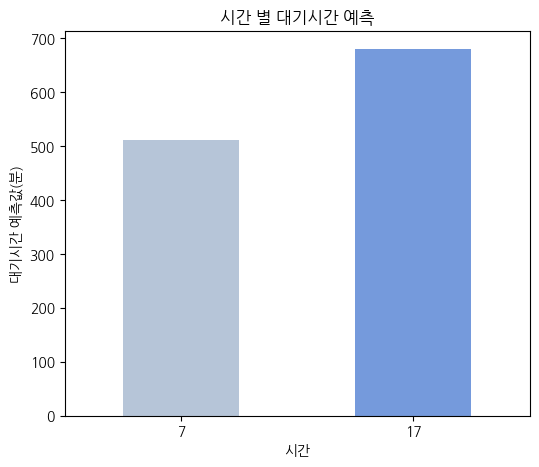

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 데이터프레임을 재구성하여 Seaborn에 적합한 형태로 만듭니다.
data = pd.DataFrame({
    'Category': filt_df['ETA_Hour'],
    'Mean_Value': filt_df['After']
})

plt.figure(figsize=(6, 5))

# Seaborn을 사용하여 막대 그래프 그리기
ax = sns.barplot(x='Category', y='Mean_Value', data=data, palette=['lightsteelblue', 'cornflowerblue'], width=0.5)  # width를 조절하여 홀쭉하게 만듭니다.

# 그래프 설정
plt.title('시간 별 대기시간 예측')
plt.xlabel('시간')
plt.ylabel('대기시간 예측값(분)')
plt.show()
